In [395]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as scs
import statsmodels as smm
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

** Merge data**

In [361]:
#list of csv names not to append
l=['Imputed with KNN=5.csv','CMU Data.csv','Merged Data.csv','DollarTradeWeighted_AdvancedEconomies.csv']

#Starting point for data alignment
startfile='CMU Data.csv'
#startfile='Imputed with KNN=5.csv'
#file path
d=os.path.dirname(os.getcwd())+'/data' 
M=pd.read_csv(os.path.join(d,startfile))
M['Timestamp']=pd.to_datetime(M['Timestamp'])
M=M.set_index('Timestamp')

#read through each file 
for filename in os.listdir(d):
    if filename[-4:]=='.csv' and filename not in l:
        with open(os.path.join(d, filename), 'r') as f: # open in read only mode
            N=pd.read_csv(os.path.join(d, filename),na_values=['.'])
            N.iloc[:,0]=pd.to_datetime(N.iloc[:,0].values)
            M=M.join(N.set_index(N.columns[0]),how='outer')
            #print(M.head())
            f.close()

M=M.iloc[::-1,:]
M.index.names = ['Time']
M.dropna(axis=0,how='all',inplace=True) #drop rows with all missing values

#save the final merged data
M.to_csv('Merged Raw.csv')

**Clean Data**

In [362]:
#read raw merged data
df=pd.read_csv('Merged Raw.csv')
#transform the datetime
df['Time']=pd.to_datetime(df['Time'])#,format='%Y-%m-%d')

print('df shape:',df.shape)
print('Columns: \n',df.columns.values)

df shape: (5213, 45)
Columns: 
 ['Time' 'Libor 1Y' 'JPY' 'EUR' 'SPX' 'VIX' '1Y OIS' 'Positioning'
 'lev Positioning' 'Signal' 'TFF1LATL INDEX' 'EURUSD CURNCY'
 'TFF1LLTL INDEX' 'TFF1LLTS INDEX' 'TFF1LATS INDEX' 'USSO1 CURNCY'
 'USDX_Close' 'mktrf' 'umd' 'TFF1LAIL INDEX' 'TFF1LLFS INDEX' 'FedFunds'
 'US0012M INDEX' 'SPX Index' 'TFF1LAIS INDEX' 'TFF1LLFL INDEX' 'T10Y3M'
 'T10Y2Y' 'T10YIE' 'Libor 3 mo' 'Libor 6 mo' 'WILL5000INDFC' 'NASDAQCOM'
 'VXVCLS' 'GVZCLS' 'GOLD_price' 'DTWEXBGS' 'VIX INDEX' 'JPYUSD CURNCY'
 'TFF1LAIN INDEX' 'SPY Flows' 'IVV' 'TFF1LLFN INDEX' 'JNK_Price'
 'JNK_Volume']


In [363]:
def plotMissing(df,save=False,title='Missing Value'):
    #Missing value plot
    plt.figure(figsize=(16,12))
    sns.heatmap(df.isnull(),cbar=False)
    #sns.heatmap(df.iloc[np.unique(np.where(df.isnull())[0]),:].isnull(),cbar=False)
    plt.title('Missing Value')
    plt.tight_layout()
    if save:
        plt.savefig(title,dpi=300)
    plt.show()

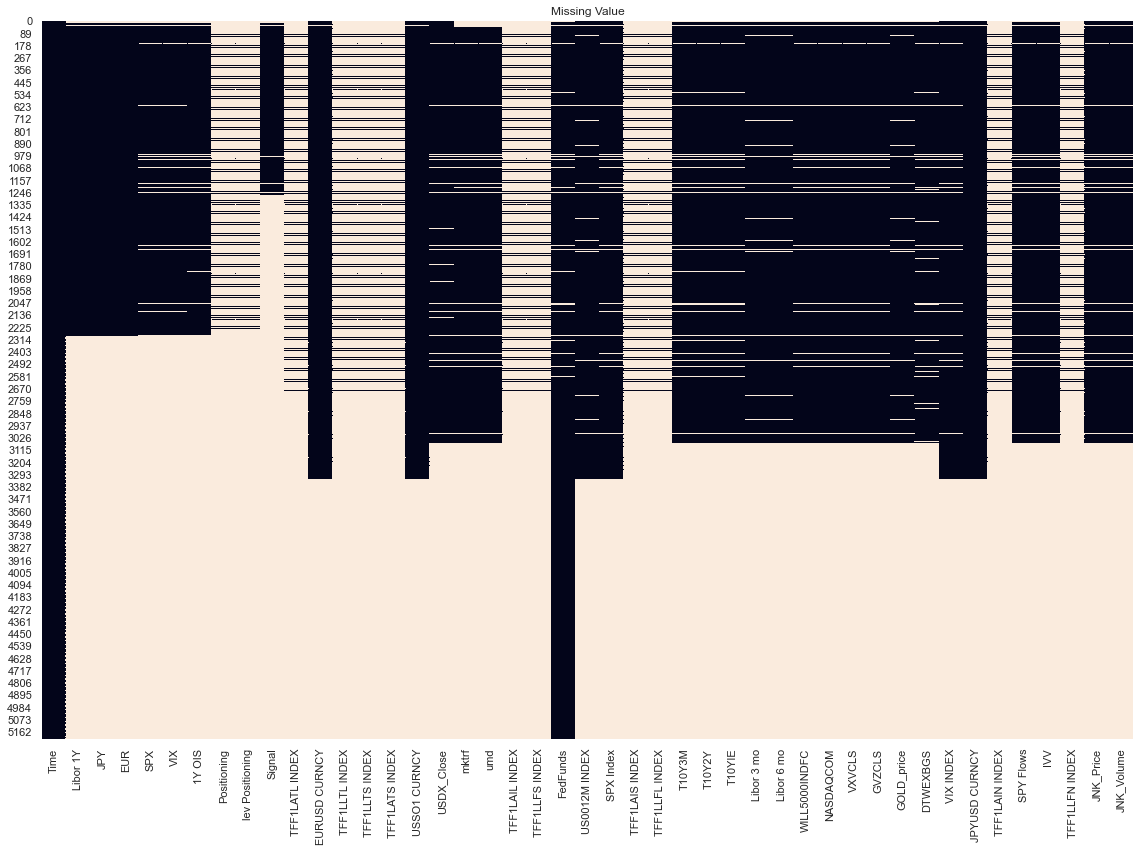

In [364]:
plotMissing(df)

In [365]:
#Select time frame from '2020-9-11' to  '2010-06-01'.
df=df['2010-06-01'<df['Time']]
df=df[df['Time']<'2020-9-11']


#Suppliment the dataset by external data source
dict={'VIX':'VIX INDEX','Libor 1Y':'US0012M INDEX','JPY':'JPYUSD CURNCY',
      'EUR':'EURUSD CURNCY','SPX':'SPX Index','1Y OIS':'USSO1 CURNCY',
     'Positioning':'TFF1LAIN INDEX','lev Positioning':'TFF1LLFN INDEX'}
#Libor 1Y: Bloomberg data consistent with Fed, NOT consistent with given data. Replace it with BBG data
#1Y OIS: same issue as Libor 1Y. 1Y OIS replaced by BBG data for now
df[list(dict.keys())]=df[list(dict.values())]
df.drop(labels=list(dict.values()),axis=1,inplace=True)


#make the whole dataframe numeric
for c in df.columns[1:]:
    df[c]=pd.to_numeric(df[c])

    
#drop all N/A rows and reindex
df.dropna(axis=0,how='all',inplace=True)
df.reset_index(drop=True,inplace=True)

Comments:

1. Set the time frame from '2020-9-11' to  '2010-06-01'.

2. Data inconsistency: 

    Libor 1Y: Bloomberg data consistent with Fed, NOT consistent with given data. Replace it with BBG data
    
    1Y OIS: same issue as Libor 1Y. 1Y OIS replaced by BBG data for now

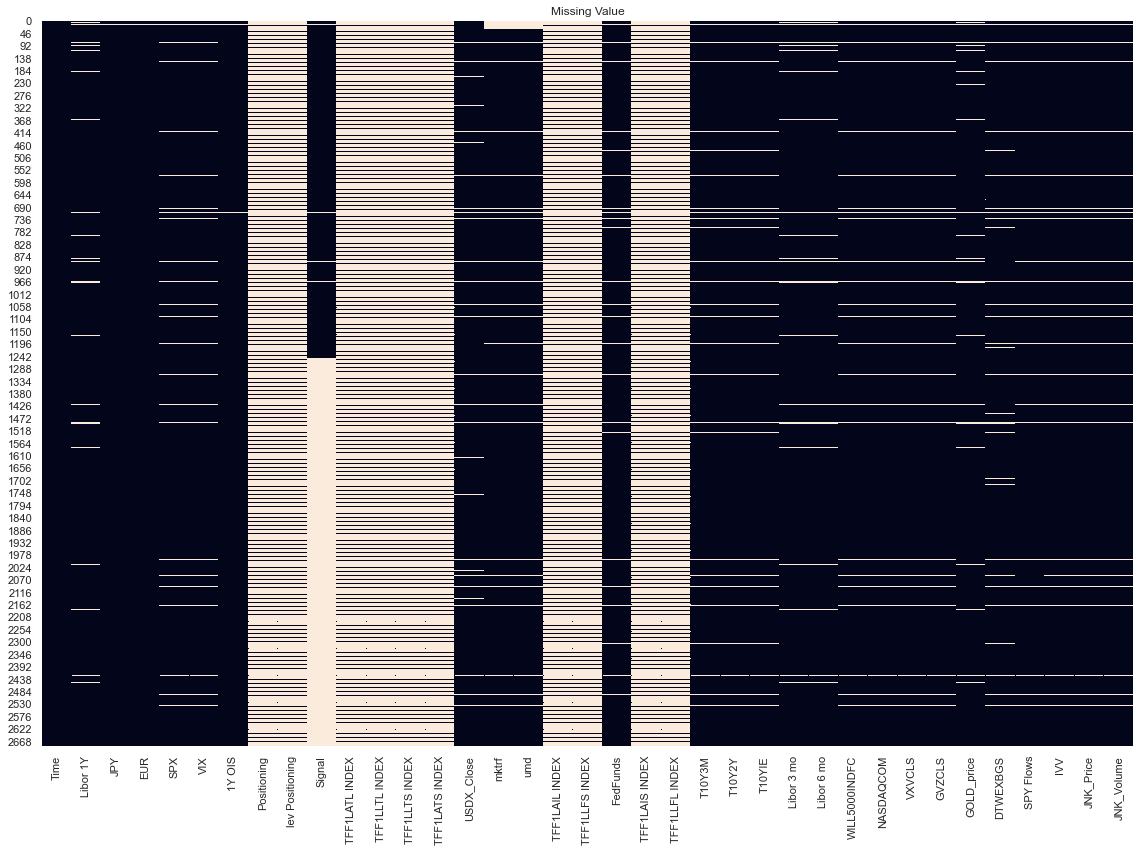

In [366]:
plotMissing(df)

**Fill missing values**

In [367]:
'''
#Impute missing values for 'SPX' 'VIX' '1Y OIS'
from sklearn.impute import KNNImputer
nn=5
imputer = KNNImputer(n_neighbors=nn)

#l=['SPX','VIX','1Y OIS','USDX_Close','mktrf','umd','JNK_Price', 'JNK_Volume','SPY Flows','IVV']
l=['USDX_Close','mktrf','umd','JNK_Price', 'JNK_Volume','SPY Flows','IVV']

data=df.copy()
data[l] = imputer.fit_transform(df[l])

#***************************
data.reset_index(drop=True,inplace=True)
#data.to_csv('Merged KNN={}.csv'.format(nn))
'''

#fill N/A with most recent data, backfill
#drop Time column and columns with weekly data 
l=df.columns
l=l.drop(['Time','Positioning','lev Positioning','TFF1LATL INDEX', 'TFF1LLTL INDEX',
       'TFF1LLTS INDEX', 'TFF1LATS INDEX','TFF1LAIL INDEX', 'TFF1LLFS INDEX', 'TFF1LAIS INDEX', 'TFF1LLFL INDEX'])
df[l]=df[l].fillna(method='backfill')
df.to_csv('Merged Final.csv')

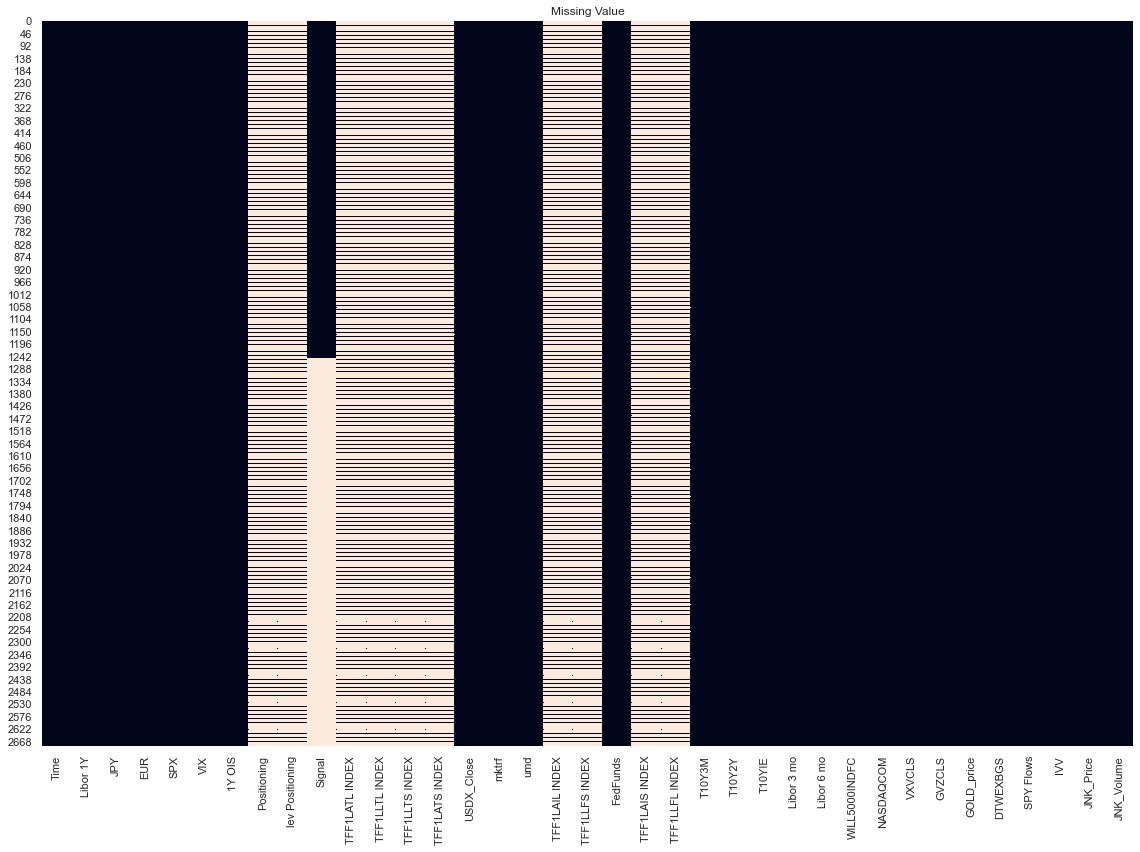

In [368]:
plotMissing(df)

**Exploratory data analysis (EDA)**

In [369]:
#All labeled data
labeled=df.drop(labels='Signal',axis=1).dropna()
print(labeled.shape)

(535, 36)


In [370]:
#check Position is reported weekly
for i in range(len(labeled)-1):
    if (labeled.iloc[i,0]-labeled.iloc[i+1,0]).days!=7:
        print('Index, as in full daily dataset, is at {}'.format(labeled.iloc[i].name))
        print('Not weekly between {} and {}: {} days'.format(
            labeled.iloc[i,0],labeled.iloc[i+1,0],(labeled.iloc[i,0]-labeled.iloc[i+1,0]).days))
print('If no index shown, positioning data is reported weekly.')

If no index shown, positioning data is reported weekly.


In [371]:
#Correlation: Compute the correlation matrix
def plotCorr(labeled,save=False):
    s=10
    corr = labeled.iloc[:,1:].corr()

    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    sns.set_theme(style="white")
    f, ax = plt.subplots(figsize=(16, 16))
    ax = sns.heatmap(corr, square=True,linewidths=.3,annot=True,cbar_kws={"shrink": .7}, mask=mask, cmap="BuPu")
    # Draw the heatmap with the mask and correct aspect ratio
    plt.tight_layout()
    plt.title('Correlation Matrix',size=s)
    if save:
        plt.savefig('Correlation Matrix',dpi=300)
    plt.show()

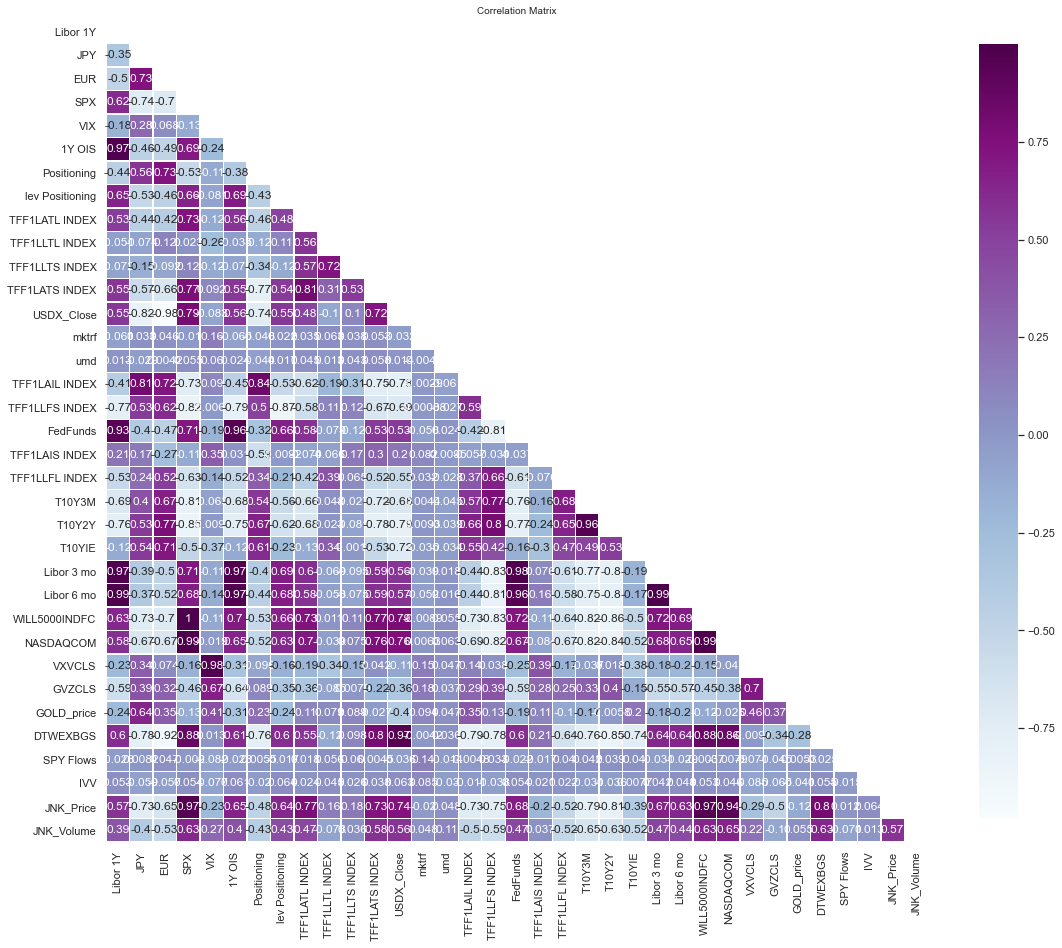

In [372]:
plotCorr(labeled)

**Split data into train/test**

In [373]:
n=df.shape[0]
test_pct=0.2
ntest=int(test_pct*n)
test,train=df.iloc[:ntest,:],df.iloc[ntest:,:]
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)
train.to_csv('train.csv')
test.to_csv('test.csv')

**More features**

In [374]:
ltrain=train.drop(labels='Signal',axis=1).dropna() #weekly data
ltrain.columns

Index(['Time', 'Libor 1Y', 'JPY', 'EUR', 'SPX', 'VIX', '1Y OIS', 'Positioning',
       'lev Positioning', 'TFF1LATL INDEX', 'TFF1LLTL INDEX', 'TFF1LLTS INDEX',
       'TFF1LATS INDEX', 'USDX_Close', 'mktrf', 'umd', 'TFF1LAIL INDEX',
       'TFF1LLFS INDEX', 'FedFunds', 'TFF1LAIS INDEX', 'TFF1LLFL INDEX',
       'T10Y3M', 'T10Y2Y', 'T10YIE', 'Libor 3 mo', 'Libor 6 mo',
       'WILL5000INDFC', 'NASDAQCOM', 'VXVCLS', 'GVZCLS', 'GOLD_price',
       'DTWEXBGS', 'SPY Flows', 'IVV', 'JNK_Price', 'JNK_Volume'],
      dtype='object')

In [375]:
#1. Slope
ltrain['SPX_1w_chg']=ltrain['SPX']/ltrain['SPX'].shift(-1)-1 #weekly pct change
ltrain['SPX_2w_chg']=ltrain['SPX']/ltrain['SPX'].shift(-2)-1 

#2. Spread
ltrain['Spread_Libor_1YOIS']=ltrain['Libor 1Y']-ltrain['1Y OIS']

#3. Lag: for comtemporary variables
l=['Positioning','lev Positioning', 'TFF1LATL INDEX', 'TFF1LLTL INDEX', 'TFF1LLTS INDEX','TFF1LATS INDEX',
      'TFF1LAIL INDEX', 'TFF1LLFS INDEX', 'TFF1LAIS INDEX', 'TFF1LLFL INDEX']
newl=['last_'+s for s in l]
ltrain[newl]=ltrain[l].shift(-1)   #TS ARIMA potential

#4. Var

#5. Cumsum

#Comments: 1.daily signal 2.time series singal

**Linear Models: no cross term**

In [376]:
ltrain=ltrain.dropna()
y=ltrain['Positioning']
X=ltrain.drop(labels=l+['Time'],axis=1)

In [389]:
from sklearn import linear_model
model = linear_model.Lasso(alpha=10,max_iter=100000).fit(X, y)

/Users/xiezhenshou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3173477019.9116535, tolerance: 187381657.3343054
  positive)


In [390]:
print(model.coef_)
print('\n',list(X.columns))

print('\nPicked out vars: ',list(X.columns[model.coef_==0]))

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.04486333e+02
 -5.75164321e+02 -0.00000000e+00  1.01738082e+03 -0.00000000e+00
  0.00000000e+00  1.17152532e+04  5.19911440e+03  5.48575627e+03
 -7.47053994e+02 -0.00000000e+00 -6.05011361e+03 -3.93439498e+03
  4.56054969e+00  3.65988712e+02 -5.67918995e+02  1.15338883e+01
 -1.40539731e+03 -2.95054191e-01  2.46871084e-01 -2.64727362e+02
 -1.00851728e-03  2.55636036e+05  7.75954522e+03  1.22184889e+03
  8.86716583e-01 -3.70866934e-02 -5.94934873e+01  5.89023368e+01
 -6.87748001e+01  1.81812075e+01  2.56249261e-02 -2.01708592e-02
  1.42099316e-01  1.60217797e-01]

 ['Libor 1Y', 'JPY', 'EUR', 'SPX', 'VIX', '1Y OIS', 'USDX_Close', 'mktrf', 'umd', 'FedFunds', 'T10Y3M', 'T10Y2Y', 'T10YIE', 'Libor 3 mo', 'Libor 6 mo', 'WILL5000INDFC', 'NASDAQCOM', 'VXVCLS', 'GVZCLS', 'GOLD_price', 'DTWEXBGS', 'SPY Flows', 'IVV', 'JNK_Price', 'JNK_Volume', 'SPX_1w_chg', 'SPX_2w_chg', 'Spread_Libor_1YOIS', 'last_Positioning', 'last_lev Positioning', 'last_TFF1L

In [399]:
def tsplot(y, lags=None, figsize = (10,8), style = 'bmh',title='Time Series of Log Ret'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan = 2)
        acf_ax = plt.subplot2grid(layout, (1,1))
        qq_ax = plt.subplot2grid(layout, (1,0))
        y.plot(ax = ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags = lags, ax=acf_ax,alpha = 0.05)
        sm.qqplot(y, line = 's', ax=qq_ax)
        qq_ax.set_title('QQ PLot')
        plt.tight_layout()
    return

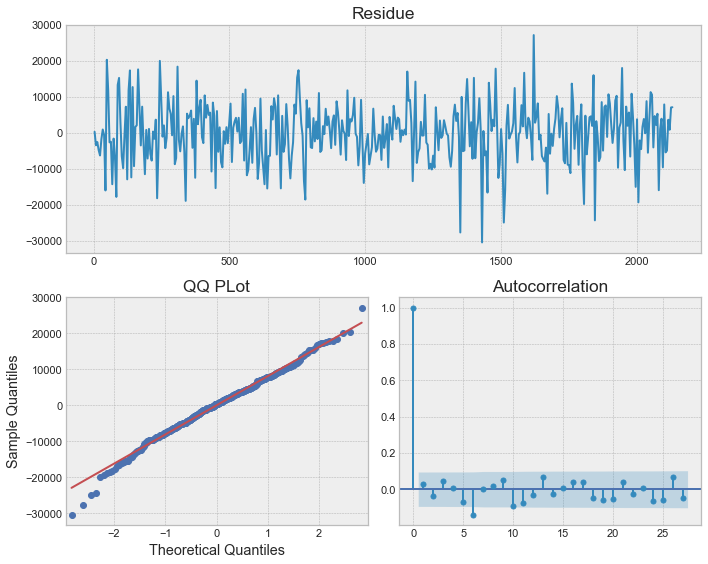

In [401]:
#look at the residue
tsplot(y-model.predict(X),title='Residue')

**Non-linear Models**

In [402]:
#TBC